In [1]:
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms
from torchvision.utils import save_image
import numpy as np
import matplotlib.pyplot as plt
import os
from datetime import datetime

In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5,),
                         std=(0.5,))
])

In [3]:
train_dataset = torchvision.datasets.MNIST(
    root='.',
    train=True,
    transform=transform,
    download=True
)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:01<00:00, 5107194.74it/s]


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 128785.69it/s]


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:01<00:00, 1091469.17it/s]


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 4726005.65it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



In [4]:
len(train_dataset)

60000

In [5]:
batch_size = 128
data_loader = torch.utils.data.DataLoader(
    dataset = train_dataset,
    batch_size = batch_size,
    shuffle = True
)

In [6]:
#Discriminator
D = nn.Sequential(
    nn.Linear(784, 512),
    nn.LeakyReLU(0.2),
    nn.Linear(512, 256),
    nn.LeakyReLU(0.2),
    nn.Linear(256, 1)
)

In [7]:
#Generator
latent_dim = 100
G = nn.Sequential(
    nn.Linear(latent_dim, 256),
    nn.LeakyReLU(0.2),
    nn.BatchNorm1d(256, momentum=0.7),
    nn.Linear(256, 512),
    nn.LeakyReLU(0.2),
    nn.BatchNorm1d(512, momentum=0.7),
    nn.Linear(512, 1024),
    nn.LeakyReLU(0.2),
    nn.BatchNorm1d(1024, momentum=0.7),
    nn.Linear(1024, 784),
    nn.Tanh()
)

In [8]:
#Set the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
D = D.to(device)
G = G.to(device)

In [9]:
#Loss and Optimizer
criterion = nn.BCEWithLogitsLoss()
d_optimizer = torch.optim.Adam(D.parameters(), lr=0.0002, betas=(0.5, 0.999))
g_optimizer = torch.optim.Adam(G.parameters(), lr=0.0002, betas=(0.5, 0.999))

In [10]:
#Scale image back to (0, 1)
def scale_image(img):
  out = (img + 1)/2
  return out

In [11]:
#Create a folder to store the generated images
if not os.path.exists('gan_images'):
  os.makedirs('gan_images')

In [12]:
#Training loop

#labels to use in the loop
ones_ = torch.ones(batch_size, 1).to(device)
zeros_ = torch.zeros(batch_size, 1).to(device)

#save losses
d_losses=[]
g_losses=[]

for epoch in range(200):
  for inputs, _ in data_loader:

    #reshape and move to device
    n = inputs.size(0)
    inputs = inputs.reshape(n, 784).to(device)

    #set ones and zeros to correct size
    ones = ones_[:n]
    zeros = zeros_[:n]

    #real images
    real_outputs = D(inputs)
    d_loss_real = criterion(real_outputs, ones)

    #fake images
    noise = torch.randn(n, latent_dim).to(device)
    fake_images = G(noise)
    fake_outputs = D(fake_images)
    d_loss_fake = criterion(fake_outputs, zeros)

    #gradient descent step
    d_loss = 0.5 * (d_loss_real + d_loss_fake)
    d_optimizer.zero_grad()
    g_optimizer.zero_grad()
    d_loss.backward()
    d_optimizer.step()

    #Train Generator
    for _ in range(2):
      #fake images
      noise = torch.randn(n, latent_dim).to(device)
      fake_images = G(noise)
      fake_outputs = D(fake_images)

      #reverse the labels
      g_loss = criterion(fake_outputs, ones)

      #gradient descent  step
      d_optimizer.zero_grad()
      g_optimizer.zero_grad()
      g_loss.backward()
      g_optimizer.step()

    #Save losses
    d_losses.append(d_loss.item())
    g_losses.append(g_loss.item())

  ###print and save things###
  print(f"Epoch: {epoch}, d_loss:{d_loss.item()}, g_loss:{g_loss.item()}")

  #PyTorch has a function to save a batch of images to file
  fake_images = fake_images.reshape(-1, 1, 28, 28)
  save_image(scale_image(fake_images), f"gan_images/{epoch+1}.png")


Epoch: 0, d_loss:0.6945866346359253, g_loss:0.6888659000396729
Epoch: 1, d_loss:0.6730747818946838, g_loss:0.7637585997581482
Epoch: 2, d_loss:0.6899734735488892, g_loss:0.7017092704772949
Epoch: 3, d_loss:0.6982985138893127, g_loss:0.8862085342407227
Epoch: 4, d_loss:0.6841872930526733, g_loss:0.7204607725143433
Epoch: 5, d_loss:0.6737583875656128, g_loss:0.7331175804138184
Epoch: 6, d_loss:0.6734318137168884, g_loss:0.7438413500785828
Epoch: 7, d_loss:0.6841357946395874, g_loss:0.7315744757652283
Epoch: 8, d_loss:0.6832833290100098, g_loss:0.7244139909744263
Epoch: 9, d_loss:0.6907672882080078, g_loss:0.7424333095550537
Epoch: 10, d_loss:0.6887688040733337, g_loss:0.7337908148765564
Epoch: 11, d_loss:0.71367347240448, g_loss:0.7287716865539551
Epoch: 12, d_loss:0.6888326406478882, g_loss:0.7296876311302185
Epoch: 13, d_loss:0.6771236062049866, g_loss:0.7318372130393982
Epoch: 14, d_loss:0.6783117055892944, g_loss:0.7530121207237244
Epoch: 15, d_loss:0.6742552518844604, g_loss:0.77873

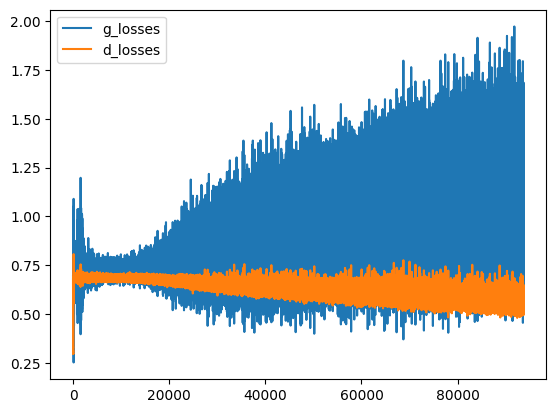

In [13]:
plt.plot(g_losses, label='g_losses')
plt.plot(d_losses, label='d_losses')
plt.legend()

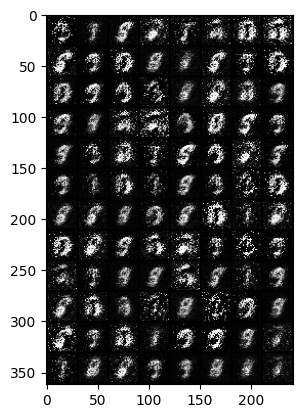

In [14]:
from skimage.io import imread
a = imread('gan_images/1.png')
plt.imshow(a)

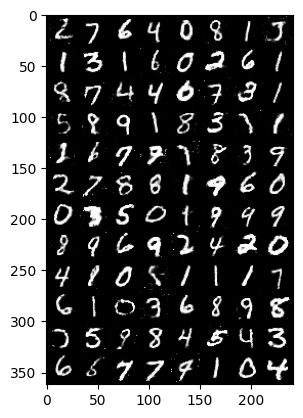

In [15]:
a = imread('gan_images/150.png')
plt.imshow(a)